# Brief

In this notebook, I'm going to perform a textual data cleaning, an EDA, an n-gram analysis and a sentiment polarity analysis (TextBlop, VADER, Stanford CoreNLP, IBM Natural Language, Flair). 

## Import Data

In [84]:
import re
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords
from tqdm import tqdm

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [82]:
rtrs_df = pd.read_csv('/kaggle/input/rtrs-brazil-public-audit-reports-2023/brazil_rtrs.csv', encoding = 'iso-8859-14', decimal = ',')

In [3]:
rtrs_df.iloc[:, 12:].head(5)

1_1_criteria  \
0  The producer demonstrates knowledge of applica...   
1  Producers demonstrated knowledge of applicable...   
2  Evidenced through documentary evaluation and i...   
3  The farm remains up to date with applicable la...   
4  Producers demonstrate knowledge of applicable ...   

                                        1_2_criteria  \
0  The right to use the land was evidenced throug...   
1  The right to use the land was evidenced throug...   
2  Evidenced through documentary evaluation of CA...   
3  The property only has its own areas with regis...   
4  The right to use the land was evidenced throug...   

                                        1_3_criteria  \
0  The manager carried out a social, environmenta...   
1  The group manager carried out a socio-environm...   
2  Evidenced through documentary evaluation, the ...   
3  First year of certification, progress will be ...   
4  The manager carried out a social, environmenta...   

                                        2_1_criteria  \
0  In none of the audited farms was there evidenc...   
1  Through interviews with permanent and temporar...   
2  According to visual assessment of signs fixed ...   
3  Employees are free to leave the farm and have ...   
4  In none of the audited farms was there evidenc...   

                                        2_2_criteria  \
0  All employees on the audited farms are registe...   
1  All workers have employment contracts signed w...   
2  According to documentary evaluation, it was ve...   
3  Employees have signed employment contracts att...   
4  All employees on the audited farms are registe...   

                                        2_3_criteria  \
0  The audited farm has a PGR, where health and s...   
1  The workers demonstrated in interviews their k...   
2  By demonstrating the delivery of PPE and healt...   
3  Those responsible for the farm demonstrated kn...   
4  All audited farms have a PGR, where health and...   

                                        2_4_criteria  \
0  According to reports obtained through intervie...   
1  Through interviews with permanent and temporar...   
2  According to interviews with managers and empl...   
3  No local union maintains contact with the empl...   
4  According to reports obtained through intervie...   

                                        2_5_criteria  \
0  Verified from interviews, information collecte...   
1  Salaries are paid monthly, according to report...   
2  According to the documentary evaluation of the...   
3  Although there is no collective agreement or c...   
4  Verified from interviews, information collecte...   

                                        3_1_criteria  \
0  The farms have e-mail and telephone numbers an...   
1  Sign verified on the propertys entrance road c...   
2  According to visual assessment, it was evident...   
3  The local community can contact the farm via t...   
4  The farms have e-mail and telephone numbers an...   

                                        3_2_criteria  ...  \
0  Verified that there are no cases of disputes r...  ...   
1  The audited properties CondomÃ­nio Milla and B...  ...   
2  Not applicable, as there are no indigenous com...  ...   
3   The farm manager/group manager has maps ident...  ...   
4  Verified that there are no cases of disputes r...  ...   

                                        5_2_criteria  \
0  The farms have complete maps with the location...   
1  As demonstrated through contracts, the CondomÃ...   
2  At Fazenda Santa Cruz, there is no use of irri...   
3  Verified during visits and on maps that forest...   
4  The farms have complete maps with the location...   

                                        5_3_criteria  \
0  Soil quality is preserved on all audited farms...   
1  Soil analyzes are carried out to monitor organ...   
2  Solid analysis carried out in 2021, issued by ...   
3  Soil analyzes are carried out with precision a...   
4  Soil quality is pres

# Clean and EDA

In [4]:
def clean_string(input_string):
    cleaned_string = unidecode.unidecode(input_string.lower())
    return re.sub(r'[^a-z0-9\s]', ' ', re.sub(r'\s+', ' ', cleaned_string))

In [5]:
rtrs_df.iloc[:, 13:].columns

Index(['1_2_criteria', '1_3_criteria', '2_1_criteria', '2_2_criteria',
       '2_3_criteria', '2_4_criteria', '2_5_criteria', '3_1_criteria',
       '3_2_criteria', '3_3_criteria', '3_4_criteria', '4_1_criteria',
       '4_2_criteria', '4_3_criteria', '4_4_criteria', '4_5_criteria',
       '5_1_criteria', '5_2_criteria', '5_3_criteria', '5_4_criteria',
       '5_5_criteria', '5_6_criteria', '5_7_criteria', '5_8_criteria',
       '5_9_criteria', '5_10_criteria', '5_11_criteria'],
      dtype='object')

In [6]:
cols_nan = rtrs_df.columns[rtrs_df.isnull().any()]

if cols_nan.empty:
    print("No MV.")
else:
    print("Cols w/ Missing Values:")
    for col in cols_nan:
        print(col)

No MV.


In [7]:
text_columns = rtrs_df.iloc[:, 12:]

In [8]:
for i in text_columns:
    text_columns[i] = text_columns[i].map(lambda x: clean_string(x))

In [9]:
def create_corpus(df, text_column='text'):
    stop = set(stopwords.words('english'))
    corpus = []
    
    for tweet in tqdm(df[text_column]):
        words = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha() == 1) and (word not in stop))]
        sentence = ' '.join(words)
        corpus.append(sentence)
    
    return corpus

In [10]:
for i in text_columns:
    text_columns[i] = create_corpus(text_columns, text_column=i)

100%|██████████| 128/128 [00:00<00:00, 5473.92it/s]


In [11]:
def analyze_text_lengths(df):
    analysis_results = []

    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)))
        sentences = sent_tokenize(' '.join(df[column].dropna().astype(str)))
        
        avg_word_length = np.mean([len(word) for word in words])
        avg_sentence_length = np.mean([len(sentence.split()) for sentence in sentences])
        
        analysis_results.append([column, avg_word_length, avg_sentence_length])
    
    return pd.DataFrame(analysis_results, columns=["Column", "Avg Word Length", "Avg Sentence Length"])

In [12]:
text_analysis_df = analyze_text_lengths(text_columns)

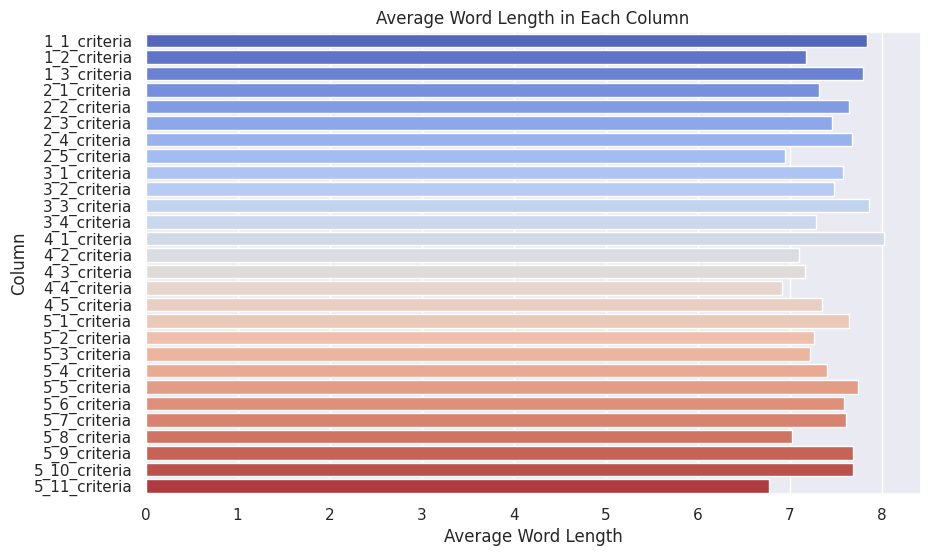

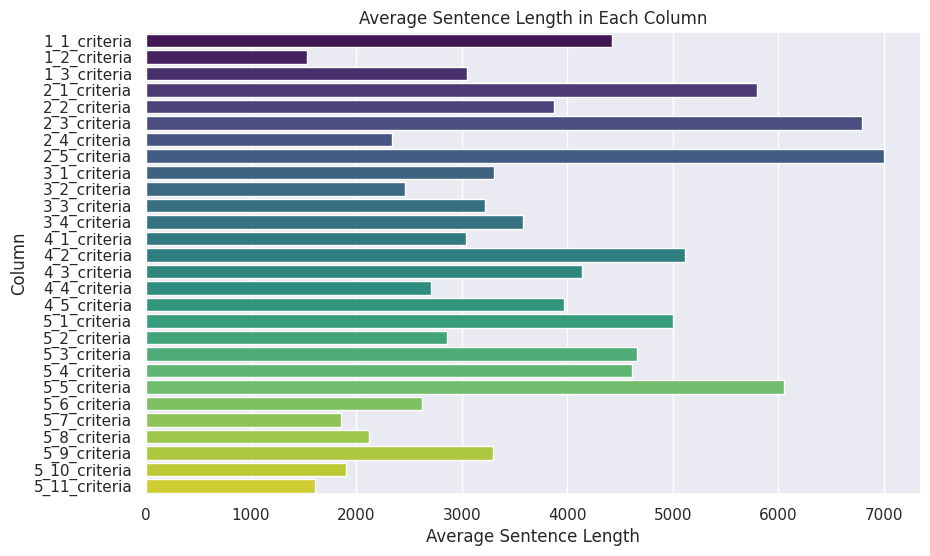

In [13]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="Avg Word Length", y="Column", data=text_analysis_df, palette="coolwarm")
plt.title("Average Word Length in Each Column")
plt.xlabel("Average Word Length")
plt.ylabel("Column")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Avg Sentence Length", y="Column", data=text_analysis_df, palette="viridis")
plt.title("Average Sentence Length in Each Column")
plt.xlabel("Average Sentence Length")
plt.ylabel("Column")
plt.show()

- Why are some columns longer than others? Is it just because of the theme of each audit criterion?

- We can answer that the specifics of each criterion vary significantly. If they are not uniform, then the statements will not be uniform either. However, there is the possibility of the text being used in indirect order, often to corroborate a certain aspect or to be evasive.


In [14]:
def word_frequency_analysis(df):
    freq_dict = {}
    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)).lower())
        word_freq = Counter(words)
        freq_dict[column] = word_freq
    return freq_dict

In [15]:
word_freqs = word_frequency_analysis(text_columns)

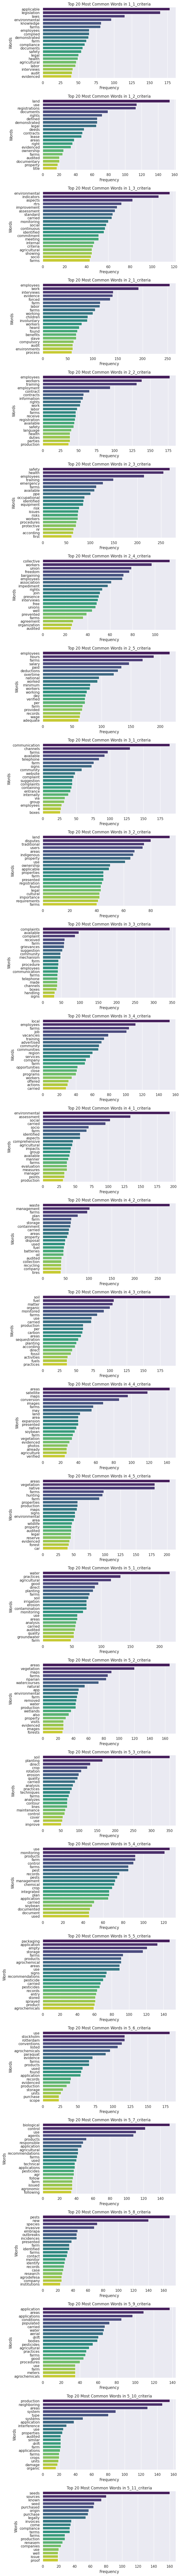

In [83]:
sns.set(style="darkgrid")

def plot_word_frequency_histograms(freq_dict):
    num_columns = len(freq_dict)

    fig, axes = plt.subplots(num_columns, 1, figsize=(8, 4 * num_columns))

    for ax, (column, freq) in zip(axes, freq_dict.items()):
        common_words = freq.most_common(20)
        words = [word[0] for word in common_words]
        counts = [word[1] for word in common_words]

        sns.barplot(x=counts, y=words, palette="viridis", ax=ax)
        ax.set_title(f"Top 20 Most Common Words in {column}")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")

    plt.tight_layout()
    plt.show()
    
plot_word_frequency_histograms(word_freqs)

In [17]:
def lexical_diversity(df):
    diversity_results = []

    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)).lower())
        diversity = len(set(words)) / len(words) if words else 0
        diversity_results.append([column, diversity])

    return pd.DataFrame(diversity_results, columns=["Column", "Lexical Diversity"])

In [18]:
diversity_df = lexical_diversity(text_columns)

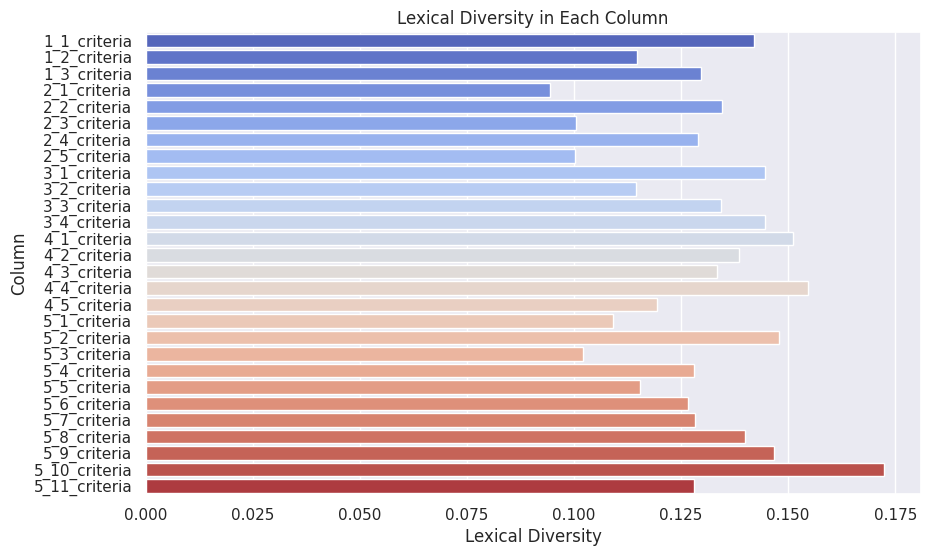

In [19]:
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="Lexical Diversity", y="Column", data=diversity_df, palette="coolwarm")
plt.title("Lexical Diversity in Each Column")
plt.xlabel("Lexical Diversity")
plt.ylabel("Column")
plt.show()

- Similarly, lexical diversity reflects not only the level of detail of each audit report observation, but also the richness of possible content.

# n-grams analysis

## bi-grams

In [20]:
def get_ngrams(df, n=2):
    all_ngrams = []
    for column in df.columns:
        words = word_tokenize(' '.join(df[column].dropna().astype(str)).lower())
        n_grams = ngrams(words, n)
        ngrams_freq = Counter(n_grams).most_common(10)

        for ngram, freq in ngrams_freq:
            all_ngrams.append([column, ' '.join(ngram), freq])

    return pd.DataFrame(all_ngrams, columns=["Column", "N-Gram", "Frequency"])

In [21]:
bigrams_df = get_ngrams(text_columns, 2)

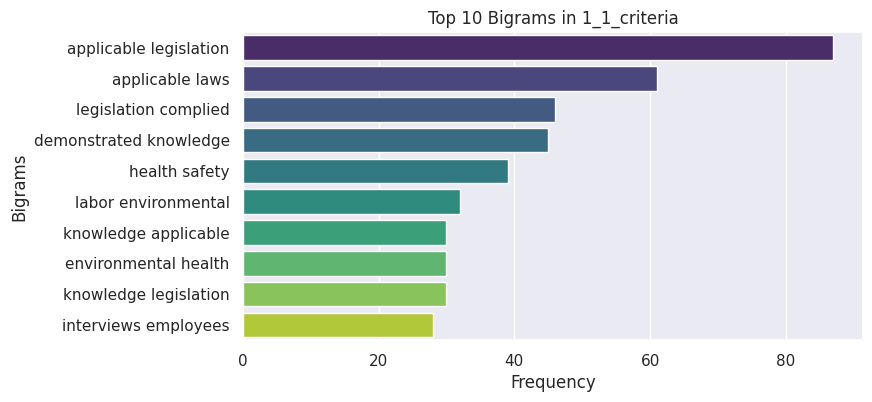

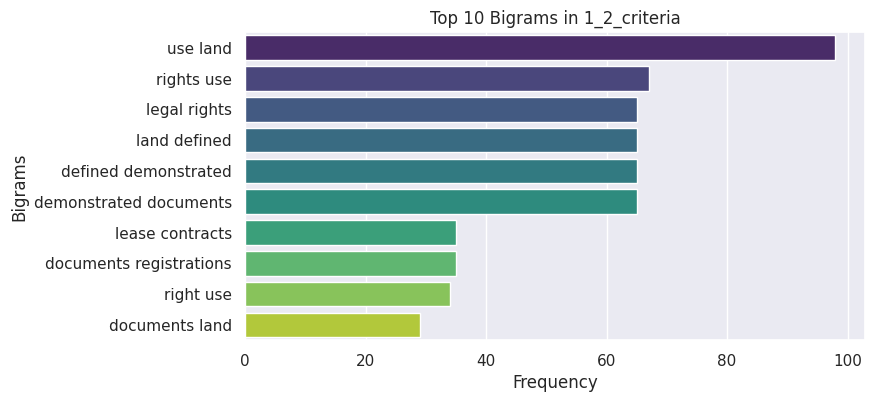

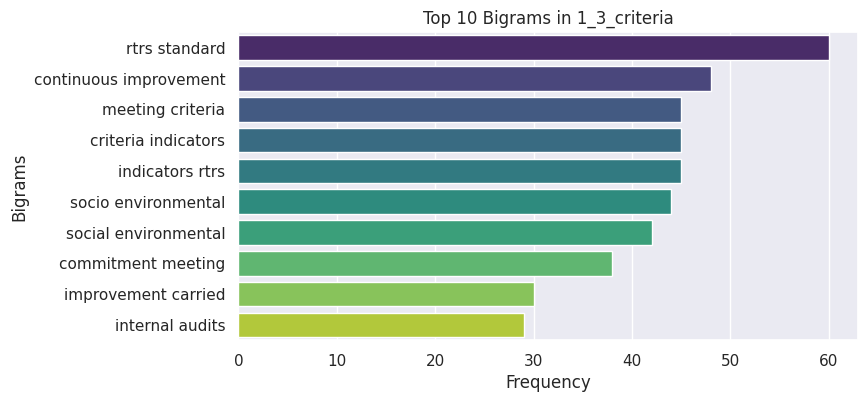

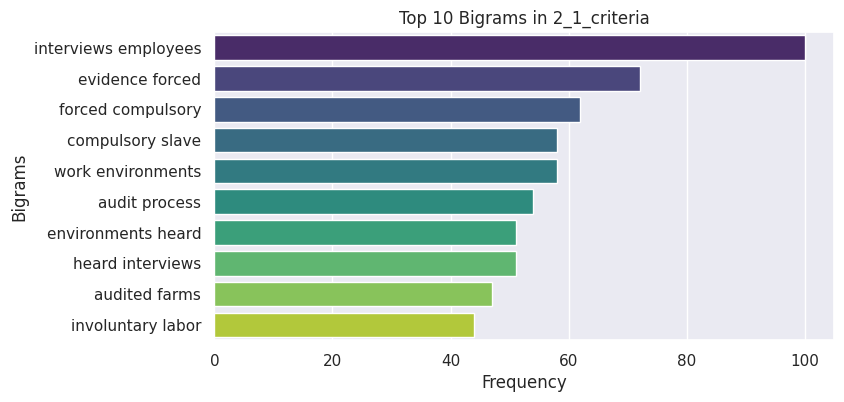

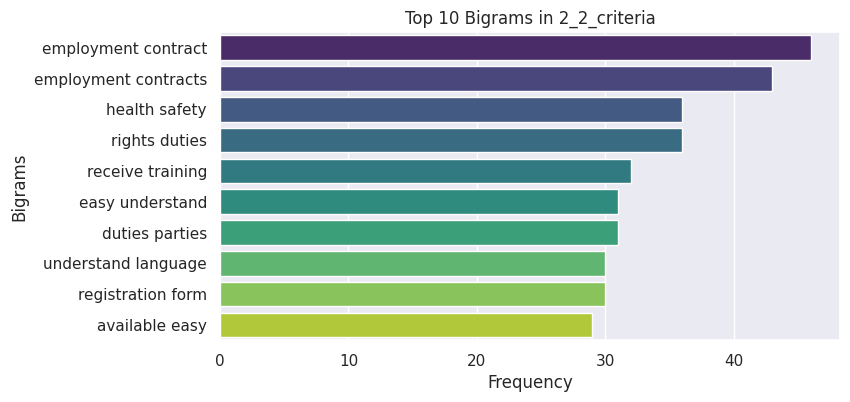

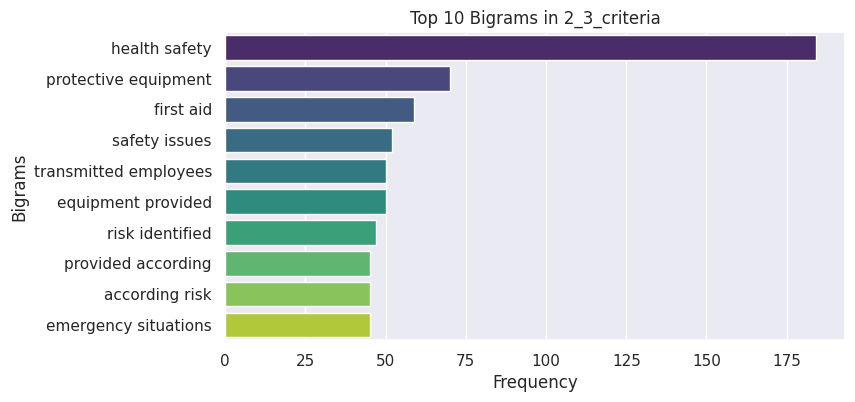

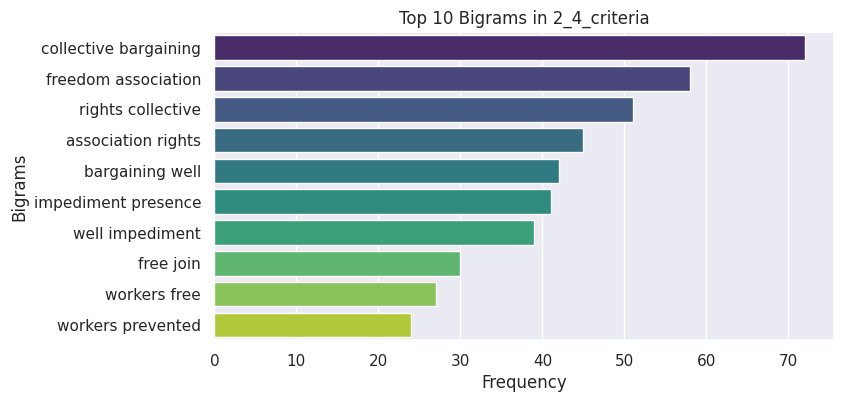

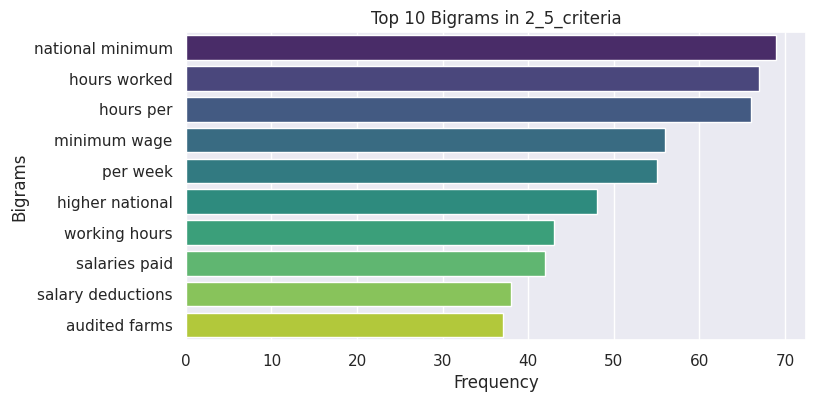

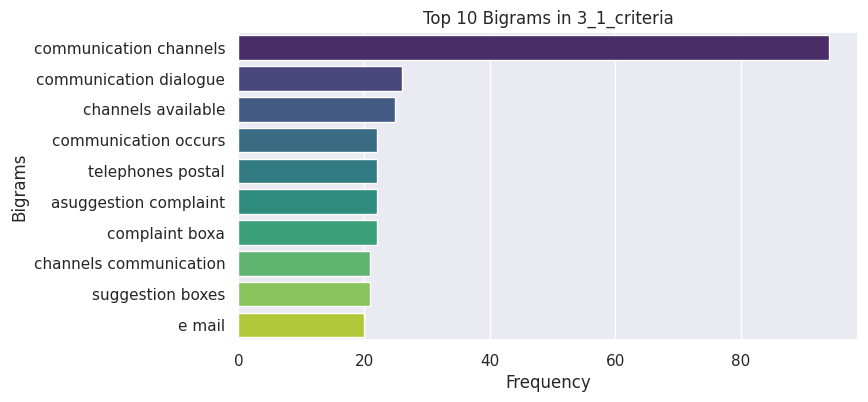

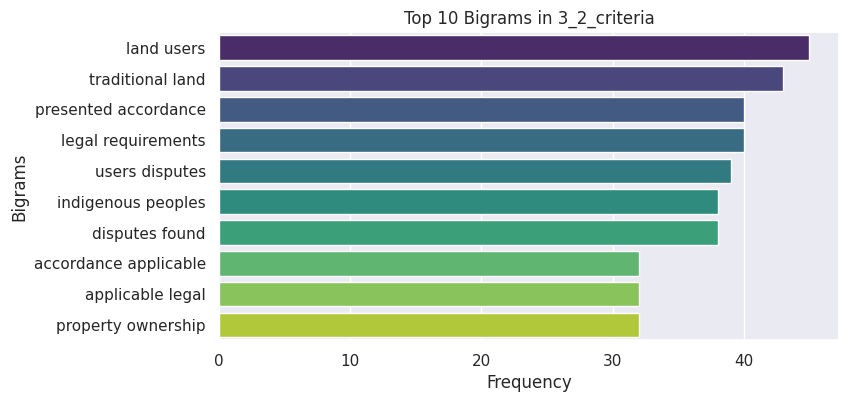

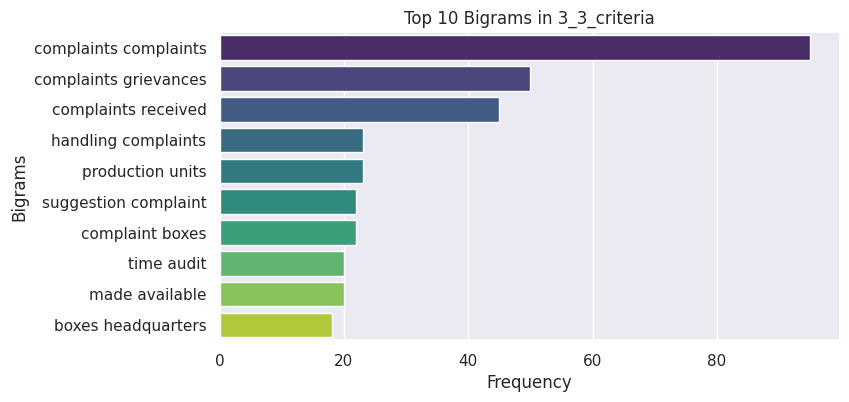

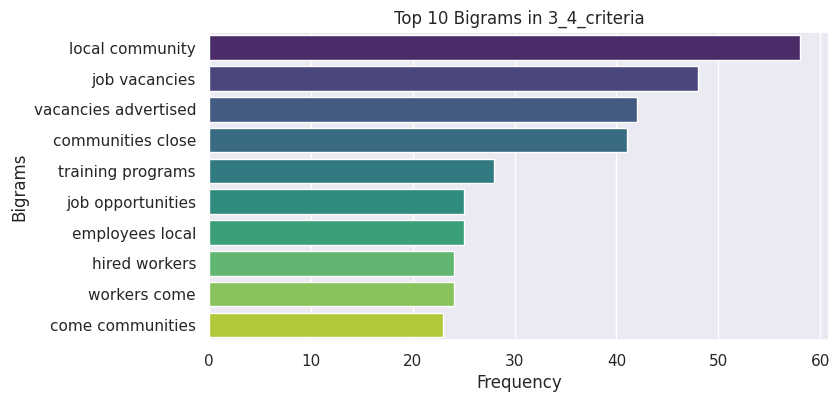

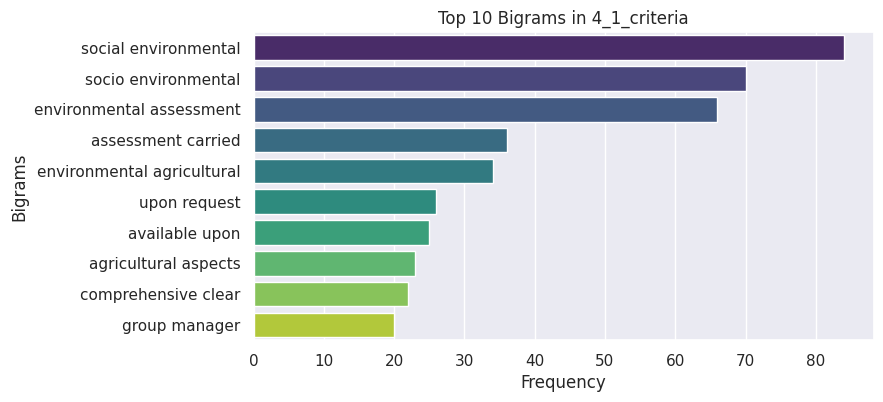

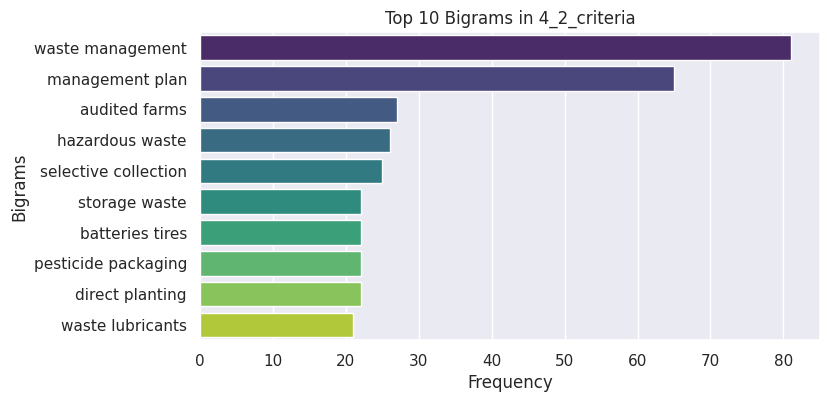

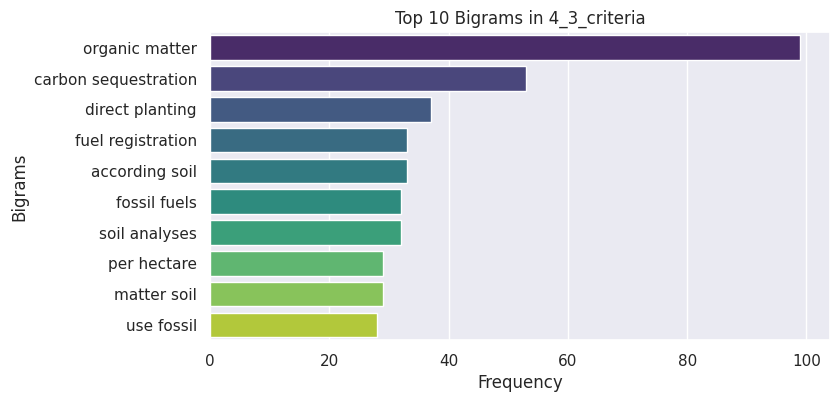

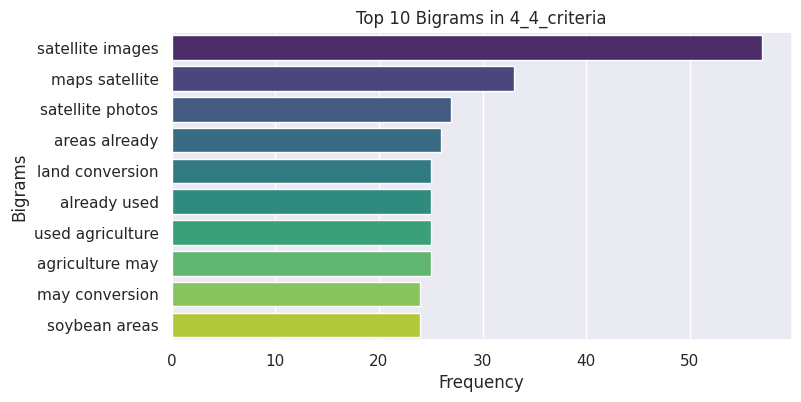

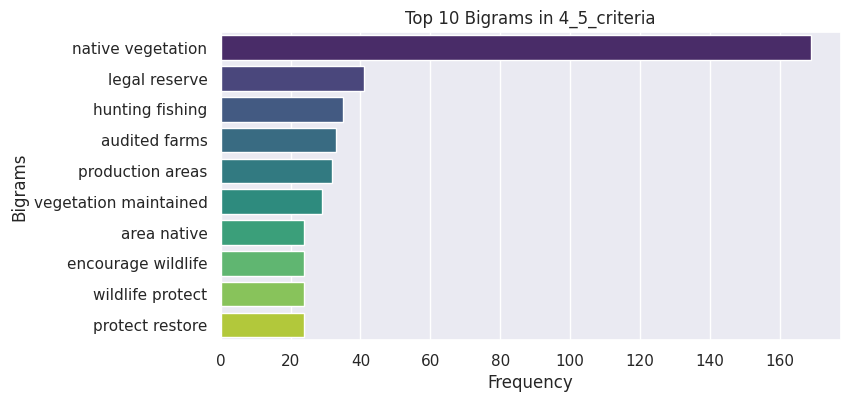

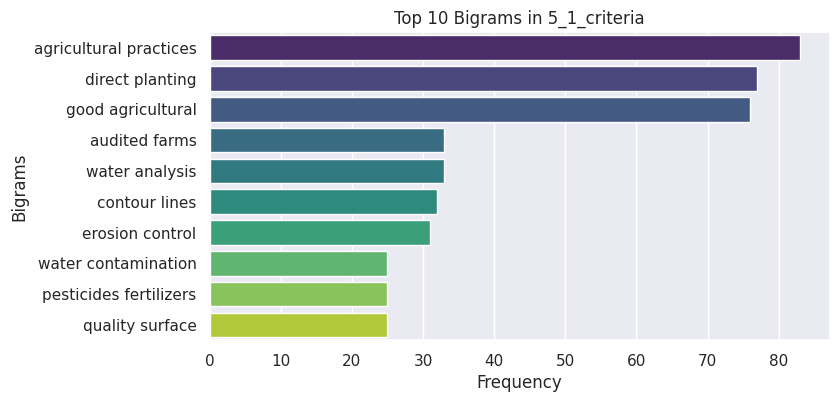

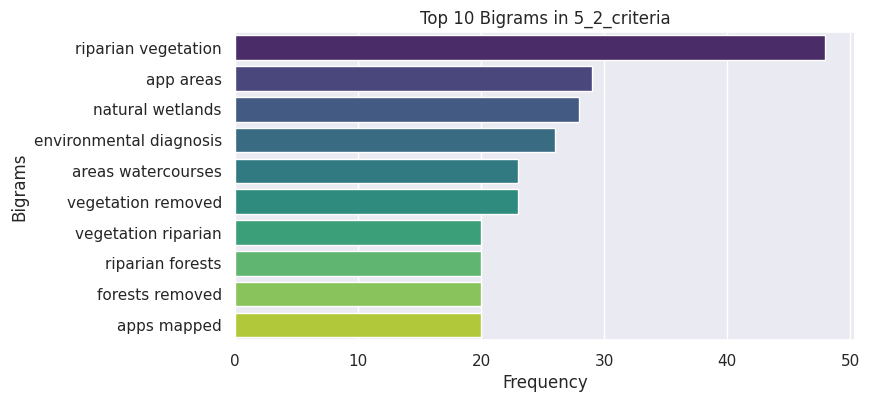

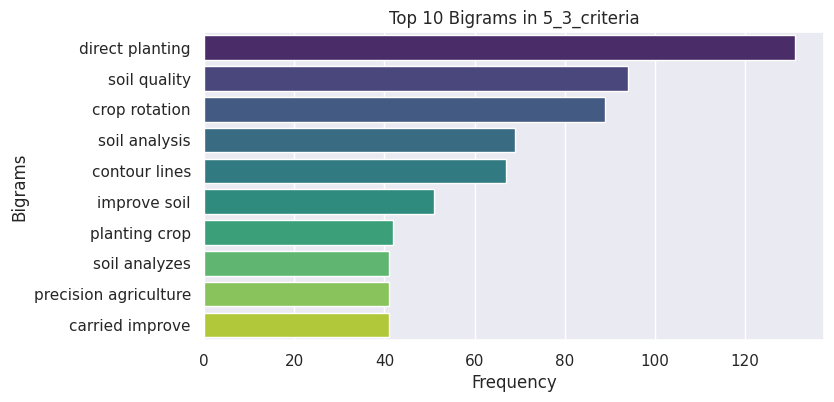

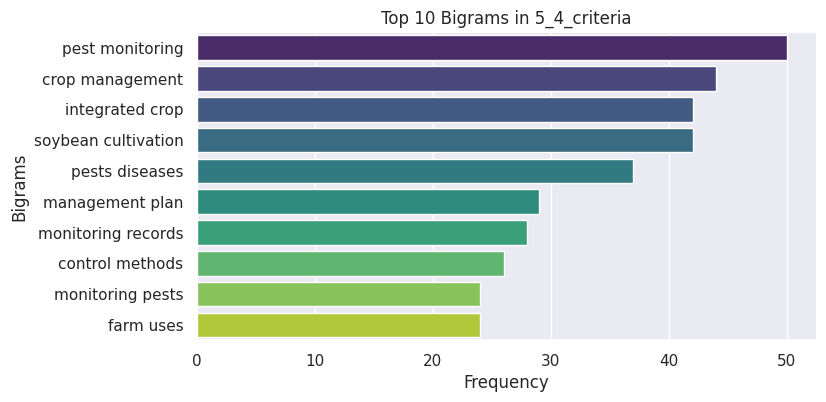

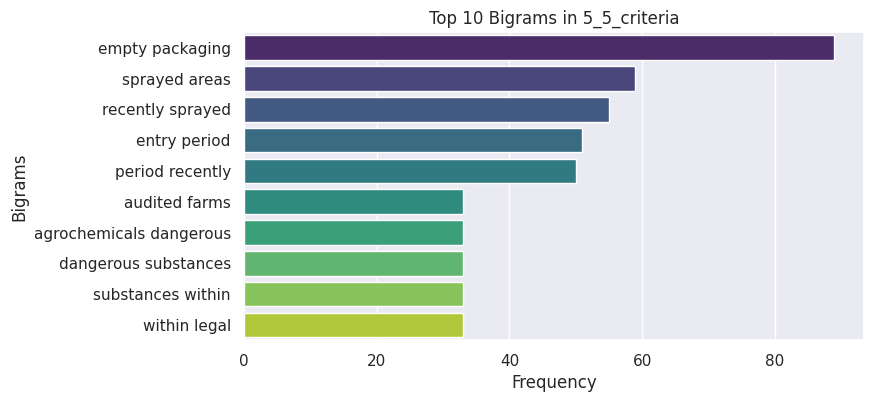

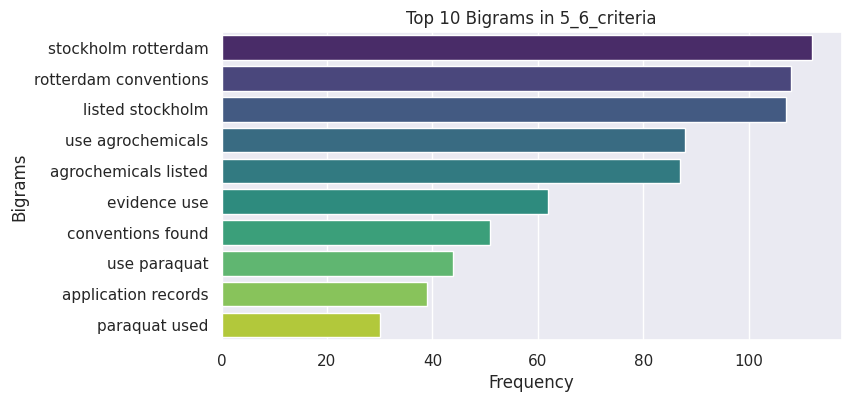

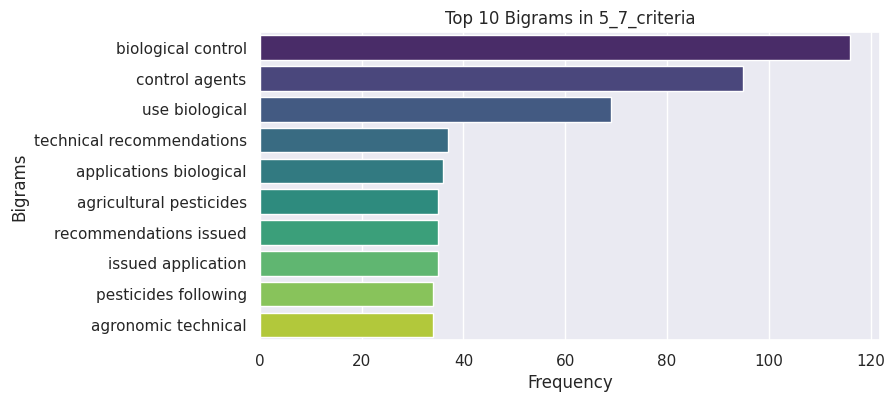

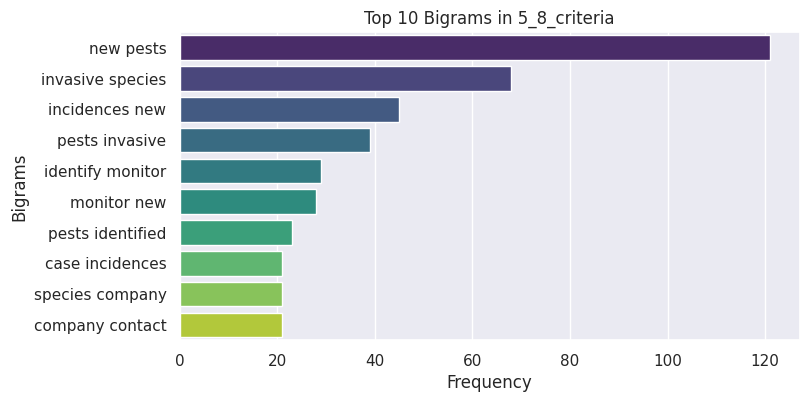

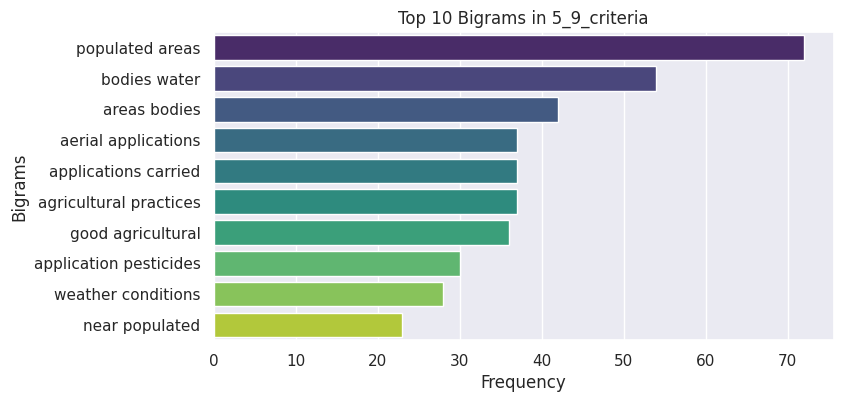

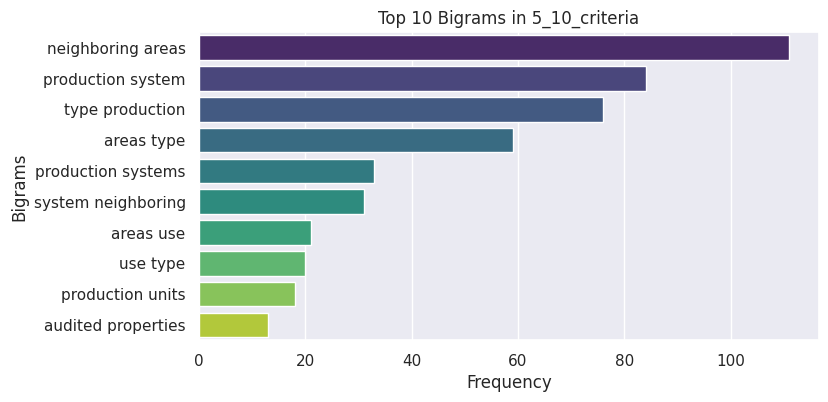

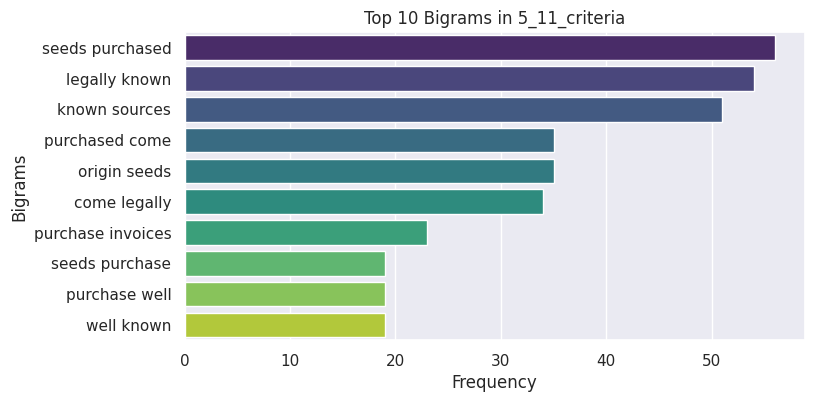

In [85]:
sns.set(style="darkgrid")

def plot_ngrams(df):
    columns = df['Column'].unique()
    for column in columns:
        sub_df = df[df['Column'] == column]
        plt.figure(figsize=(8, 4))
        sns.barplot(x="Frequency", y="N-Gram", data=sub_df, palette="viridis")
        plt.title(f"Top 10 Bigrams in {column}")
        plt.xlabel("Frequency")
        plt.ylabel("Bigrams")
        plt.show()

plot_ngrams(bigrams_df)

## tri-grams

In [25]:
trigrams_df = get_ngrams(text_columns, 3)

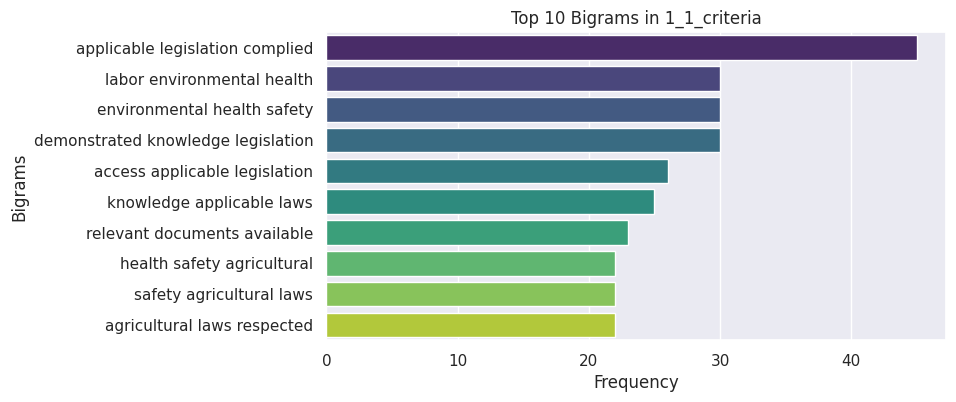

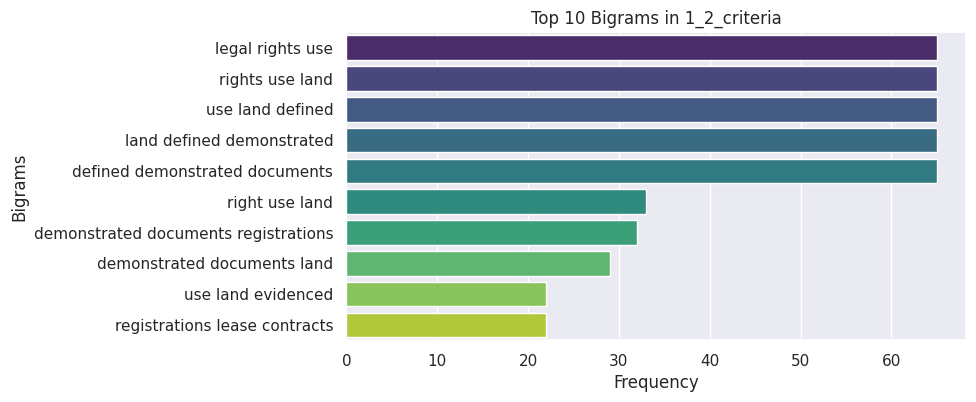

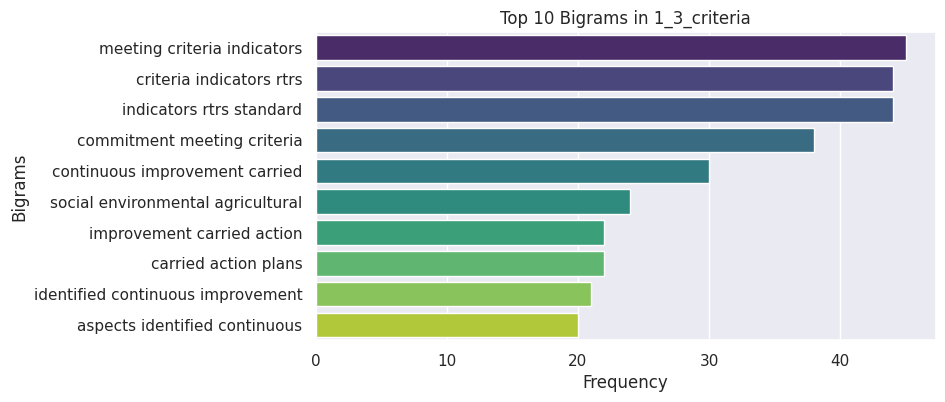

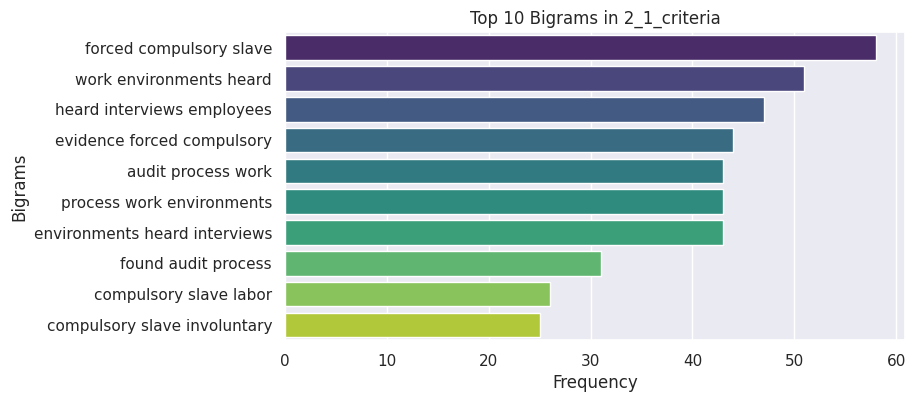

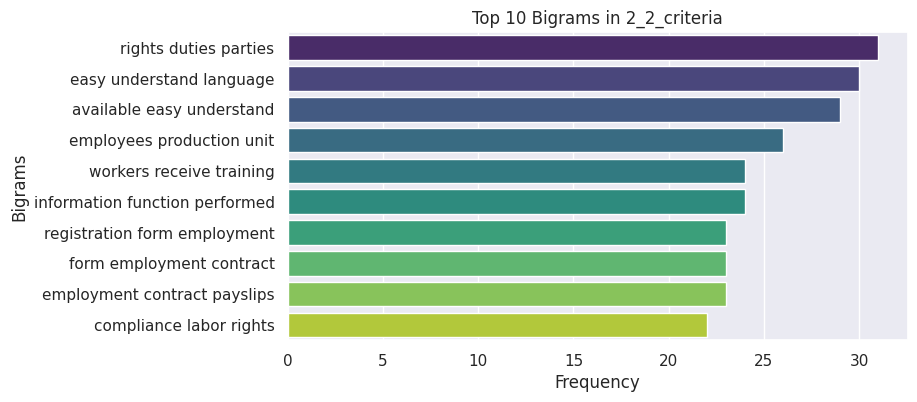

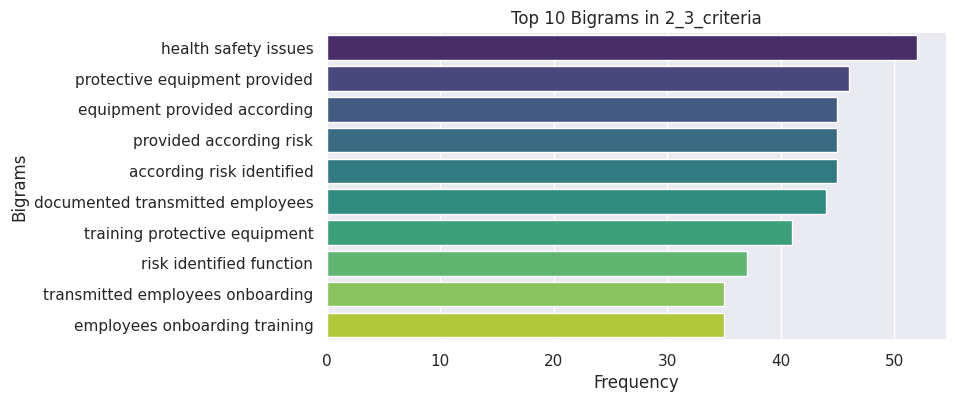

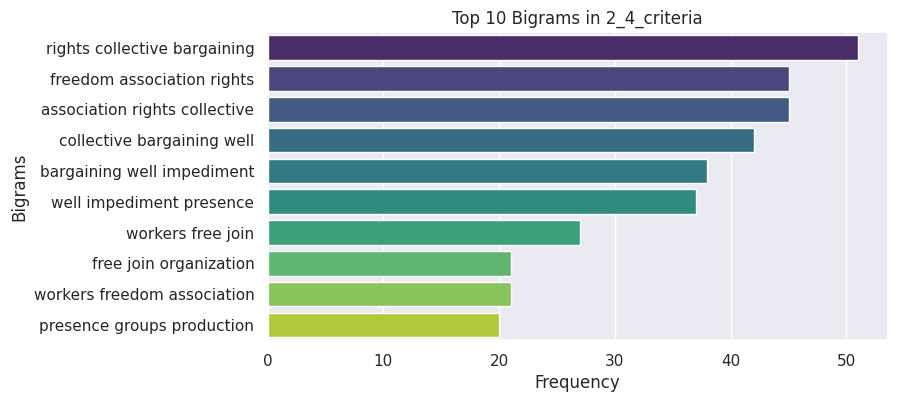

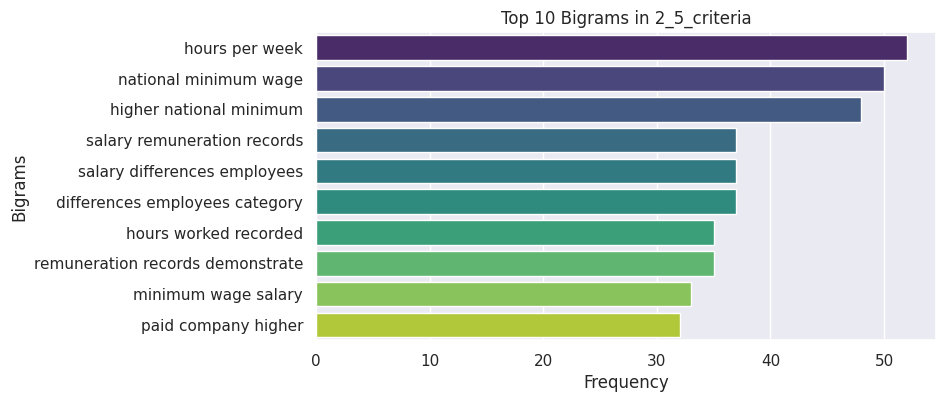

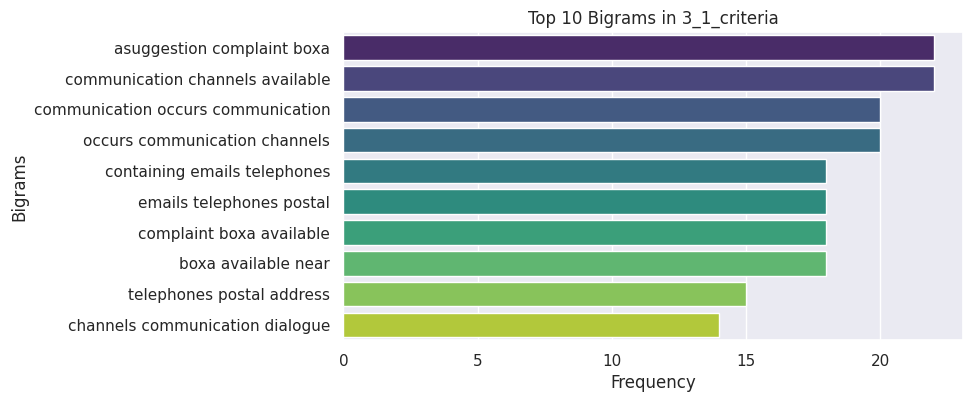

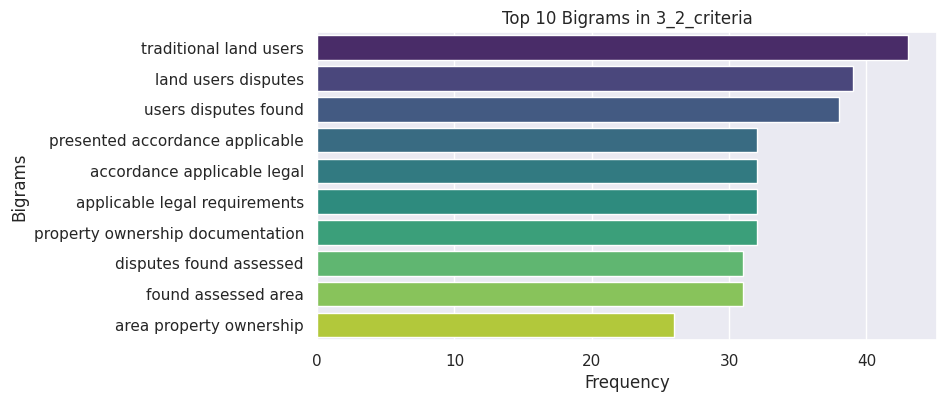

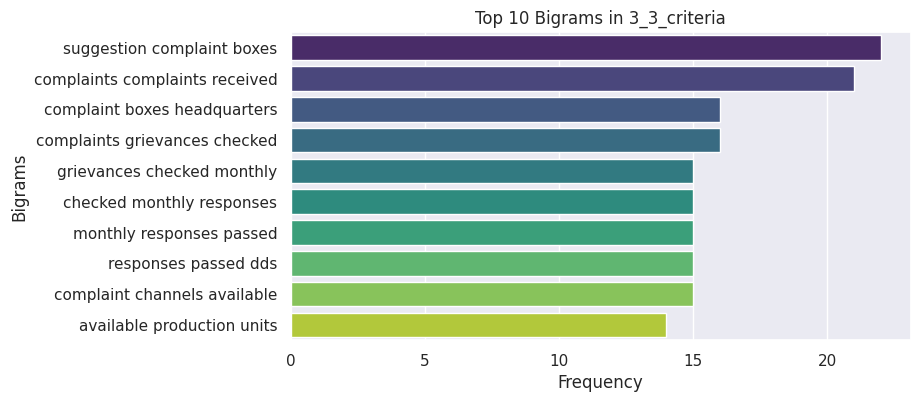

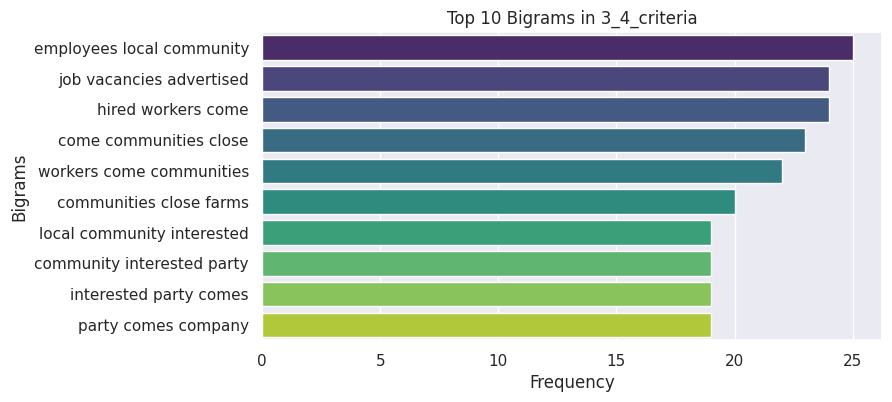

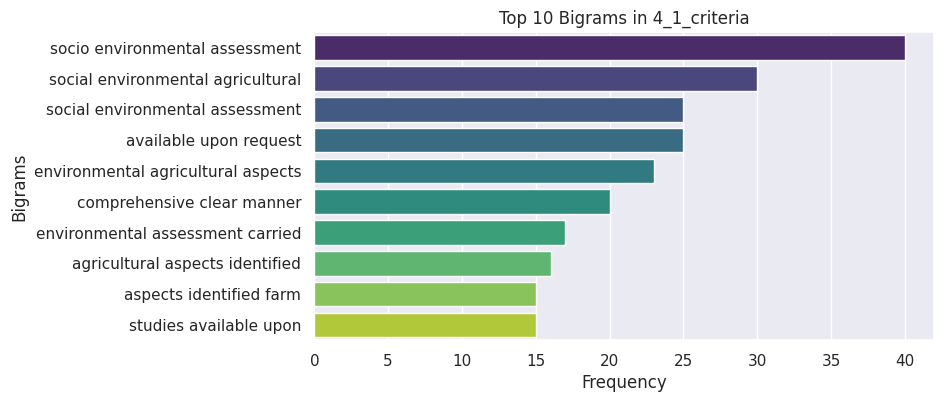

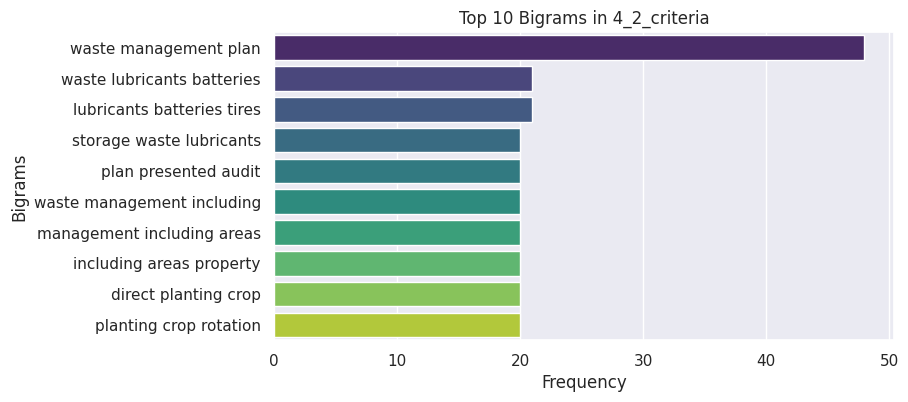

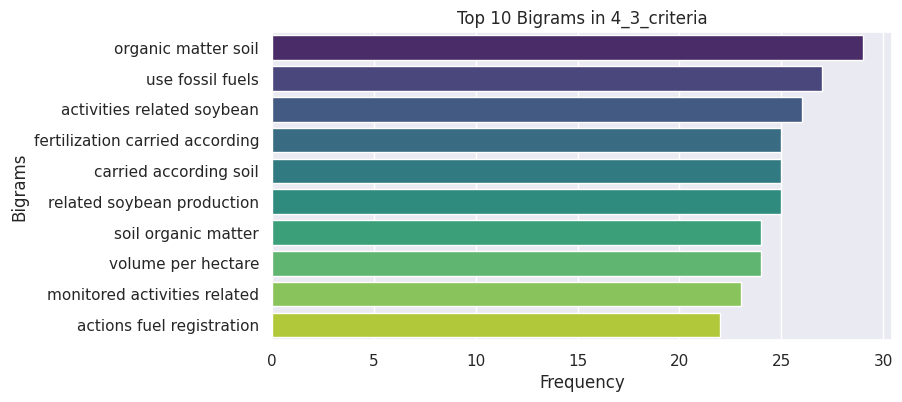

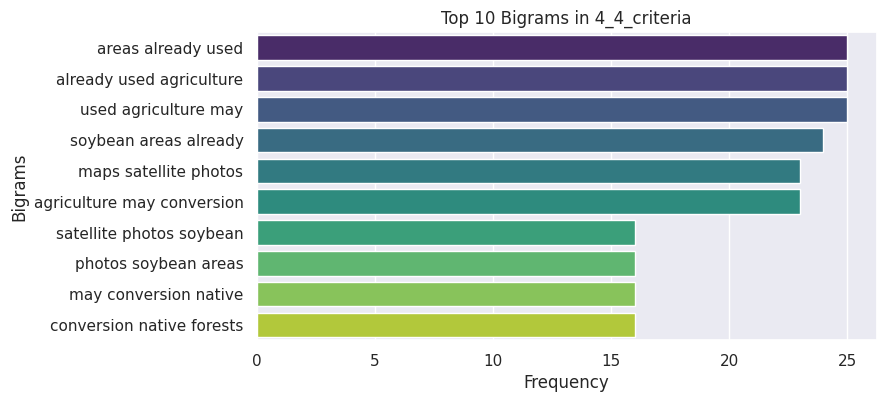

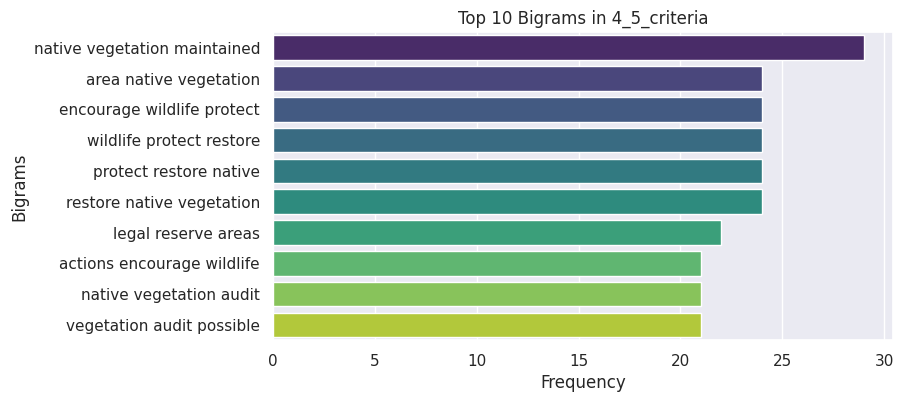

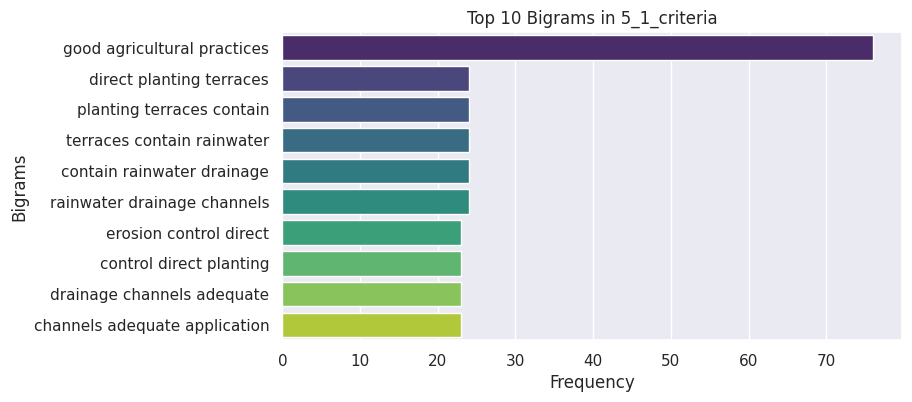

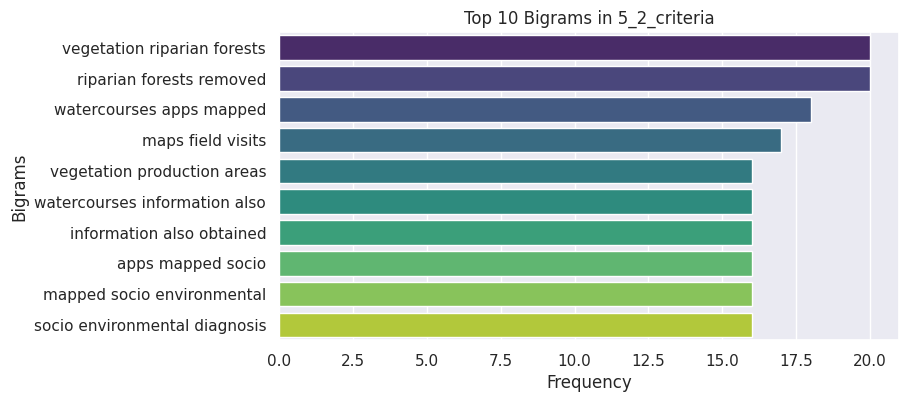

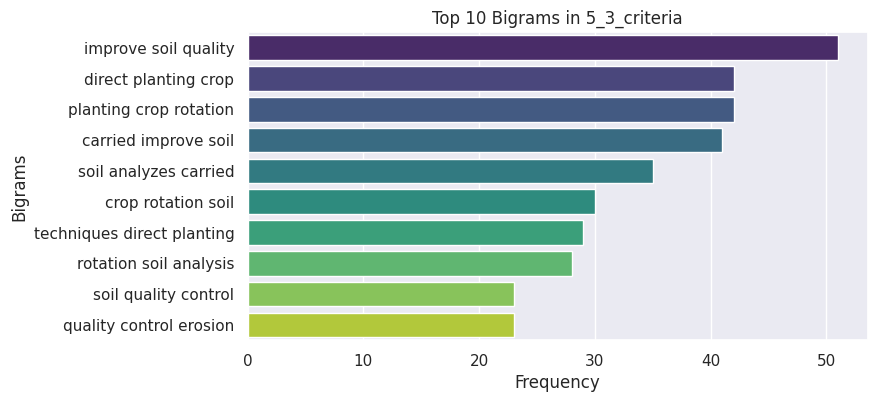

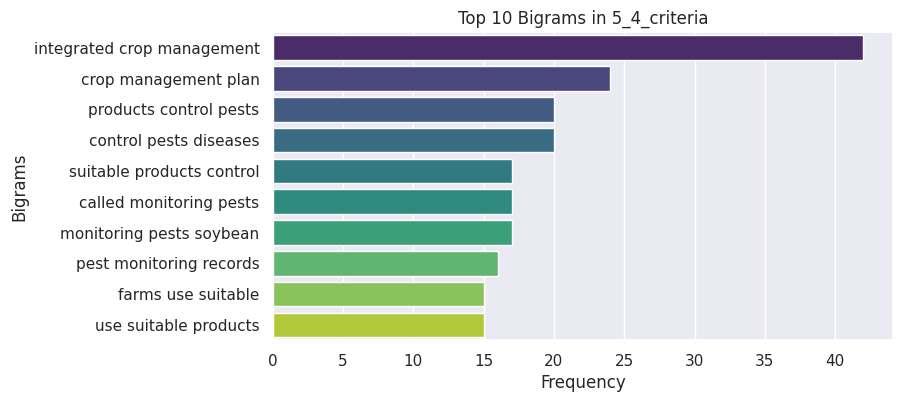

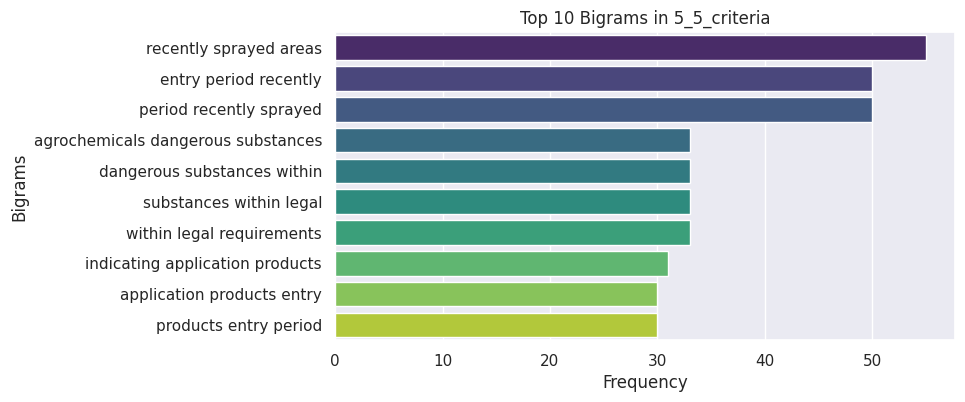

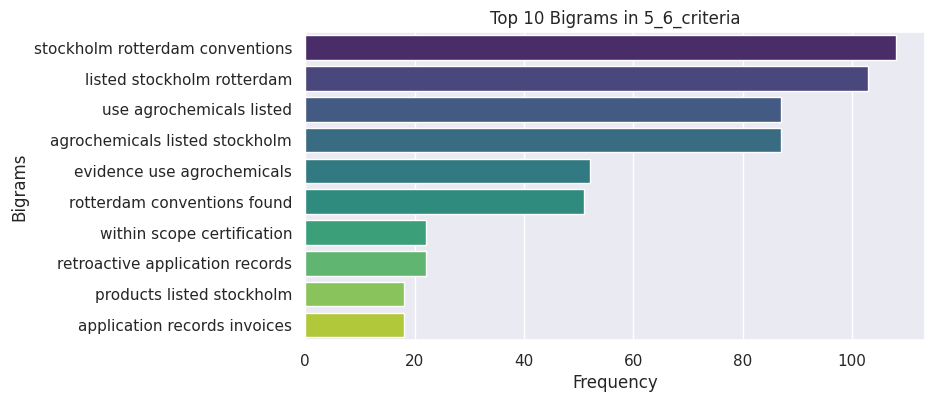

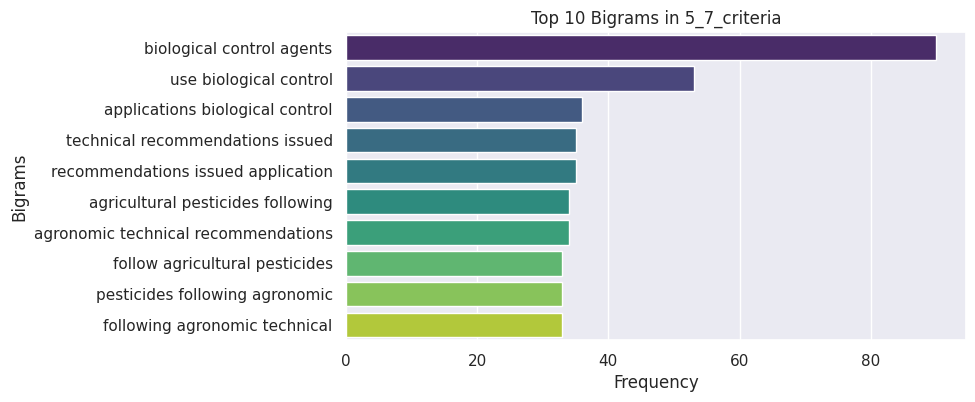

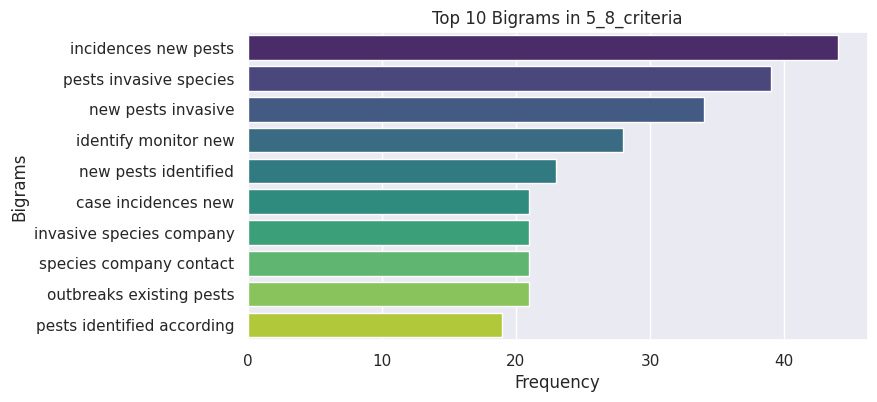

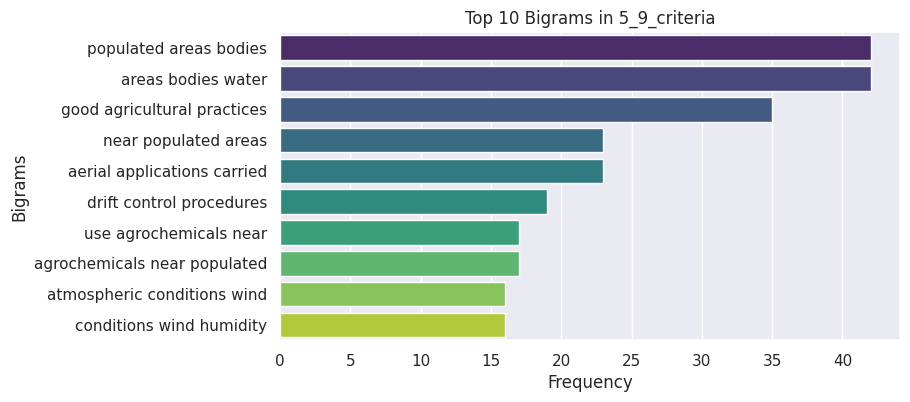

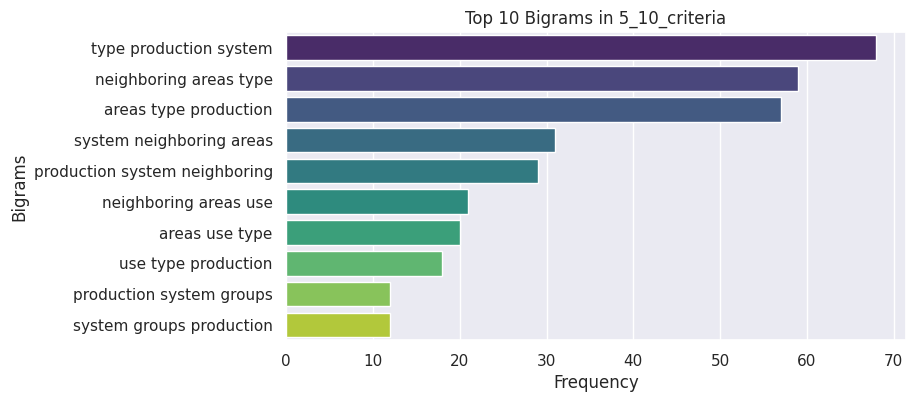

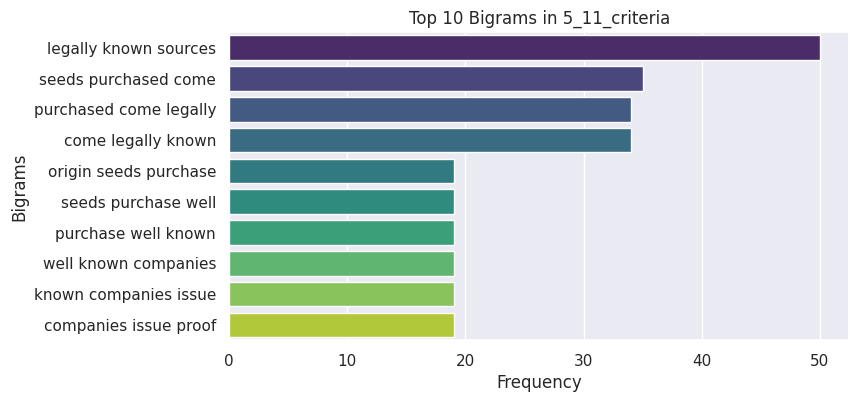

In [86]:
sns.set(style="darkgrid")

plot_ngrams(trigrams_df)

# Sentiment Polarity Analysis (TextBlop)

In [23]:
from textblob import TextBlob

def sentiment_analysis(df):
    sentiment_results = []
    for column in df.columns:
        text = ' '.join(df[column].dropna().astype(str))
        blob = TextBlob(text)
        sentiment = blob.sentiment.polarity
        sentiment_results.append([column, sentiment])
    return pd.DataFrame(sentiment_results, columns=["Column", "Polarity"])

In [24]:
sentiment_df = sentiment_analysis(text_columns)

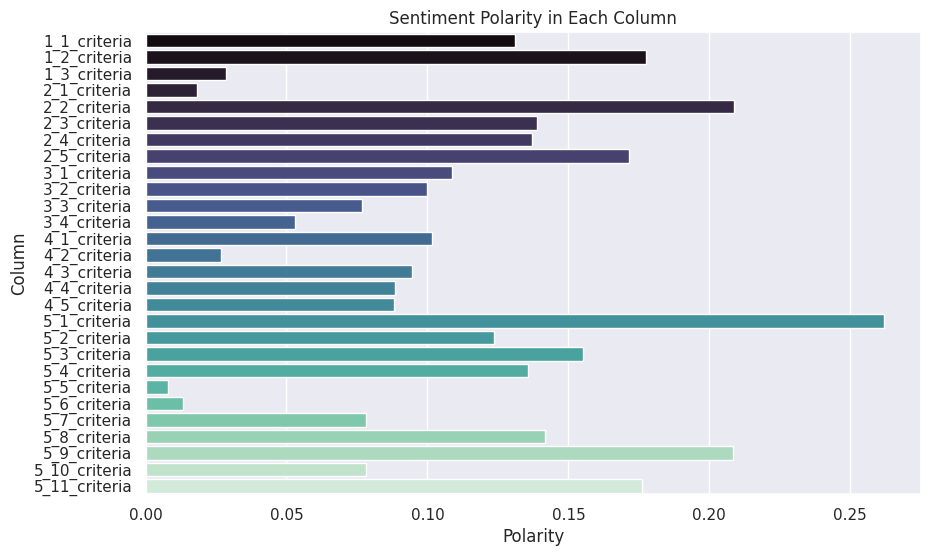

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Polarity", y="Column", data=sentiment_df, palette="mako")
plt.title("Sentiment Polarity in Each Column")
plt.xlabel("Polarity")
plt.ylabel("Column")
plt.show()

# VADER (Valence Aware Dictionary and sEntiment Reasoner)

In [28]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

def sentiment_analysis_vader(df):
    sia = SentimentIntensityAnalyzer()
    sentiment_results = []

    for column in df.columns:
        text = ' '.join(df[column].dropna().astype(str))
        sentiment = sia.polarity_scores(text)['compound']
        sentiment_results.append([column, sentiment])

    return pd.DataFrame(sentiment_results, columns=["Column", "Compound Score"])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [30]:
vader_result_df = sentiment_analysis_vader(text_columns)

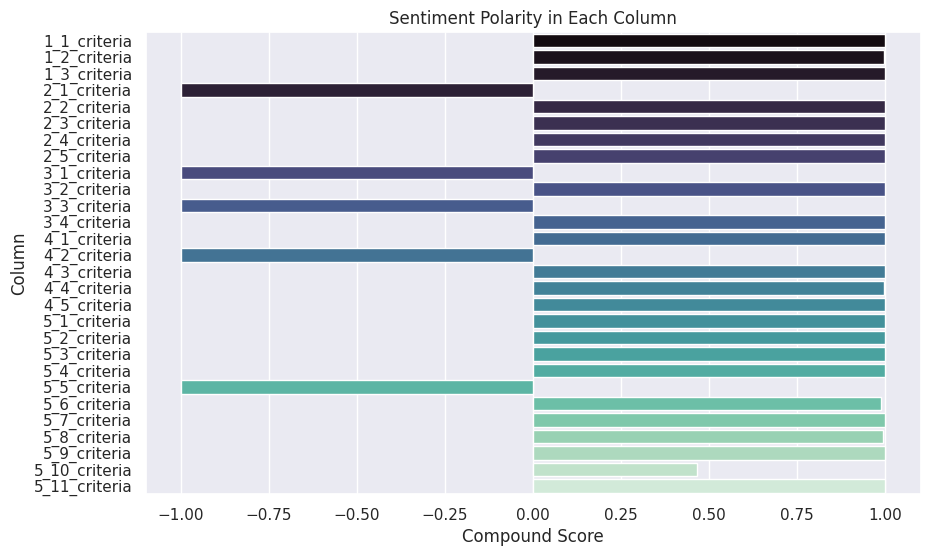

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Compound Score", y="Column", data=vader_result_df, palette="mako")
plt.title("Sentiment Polarity in Each Column")
plt.xlabel("Compound Score")
plt.ylabel("Column")
plt.show()

# IBM Natural Language Understanding

In [44]:
!pip install ibm-watson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.3/389.3 kB 7.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 11.0 MB/s eta 0:00:00
  Created wheel for ibm-watson: filename=ibm_watson-7.0.1-py3-none-any.whl size=389784 sha256=bc5f7a52b00e96a237b4e768225295d200109cd3ecfbe4fd7567edf4d0fca5b1
  Stored in directory: /root/.cache/pip/wheels/34/df/f4/f8edc5ba0637dd4bfb2029741ae20402976a49d1b6bc113553
  Created wheel for ibm-cloud-sdk-core: filename=ibm_cloud_sdk_core-3.18.2-py3-none-any.whl size=94323 sha256=9bfc58576b576166cda04db86e7d9dd8c41d1a9df39f3bd3c9421a102bdb0a4e
  Stored in directory: /root/.cache/pi

In [45]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("ibm-nlu")
secret_value_1 = user_secrets.get_secret("ibm-nlu-url")

In [46]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

authenticator = IAMAuthenticator(secret_value_0)
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2021-08-01',
    authenticator=authenticator
)

natural_language_understanding.set_service_url(secret_value_1)

def sentiment_analysis_ibm_watson(df):
    sentiment_results = []

    for column in df.columns:
        text = ' '.join(df[column].dropna().astype(str))
        response = natural_language_understanding.analyze(
            text=text,
            features=Features(sentiment=SentimentOptions())
        ).get_result()
        
        sentiment_score = response['sentiment']['document']['score']
        sentiment_results.append([column, sentiment_score])

    return pd.DataFrame(sentiment_results, columns=["Column", "Sentiment Score"])

In [47]:
ibm_result_df = sentiment_analysis_ibm_watson(text_columns)

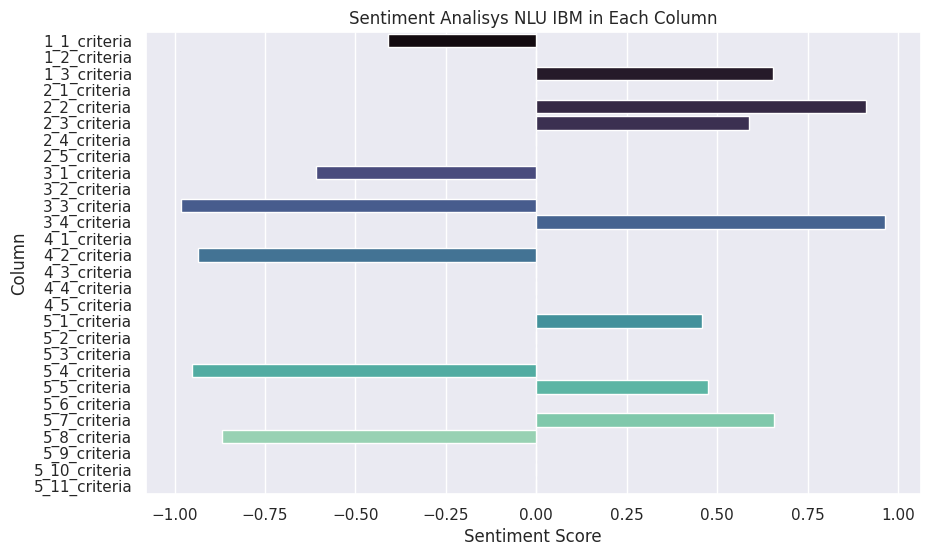

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Sentiment Score", y="Column", data=ibm_result_df, palette="mako")
plt.title("Sentiment Analisys NLU IBM in Each Column")
plt.xlabel("Sentiment Score")
plt.ylabel("Column")
plt.show()

# Flair

In [53]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 7.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 47.8 MB/s eta 0:00:0000:0100:01
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=b7efb8a8bfdfd0d43056617304d98ea0c76f737fbe3ea28764cb7b3d31f0a25d
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
  Created wheel for pptree: filename=pptree-3.1-py3-none-any.whl size=4609 sha256=060bb7b85e0bebedc768fde4078ae69c9a61df924ec7bd5708093b6ad0f92ffb
  Stored in directory: /root/.cache/pip/wheels/9f/b6/0e/6f26eb9e6eb53ff2107a7888d72b5a6a597593956113037828
  Created wheel

In [67]:
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')

def sentiment_analysis_flair(df):
    sentiment_results = []

    for column in df.columns:
        text = ' '.join(df[column].dropna().astype(str))
        sentence = Sentence(text)
        classifier.predict(sentence)
        sentiment_label = sentence.labels[0]
        
        sentiment = sentiment_label.value  
        confidence = sentiment_label.score  

        sentiment_numeric = 1 if sentiment == 'POSITIVE' else -1
        sentiment_results.append([column, sentiment_numeric, round(confidence, 4)])

    return pd.DataFrame(sentiment_results, columns=["Column", "Sentiment", "Confidence"])

In [68]:
flair_result_df = sentiment_analysis_flair(text_columns)

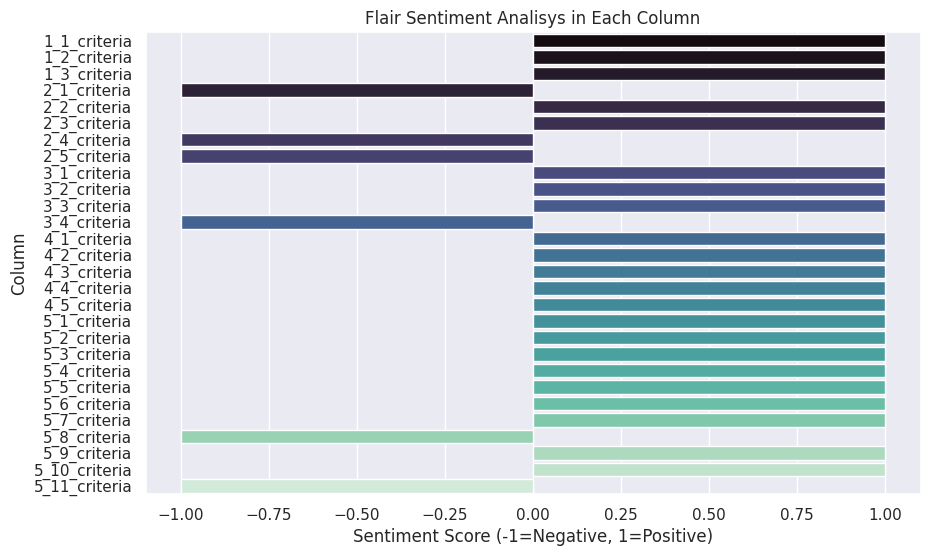

In [69]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Sentiment", y="Column", data=flair_result_df, palette="mako")
plt.title("Flair Sentiment Analisys in Each Column")
plt.xlabel("Sentiment Score (-1=Negative, 1=Positive)")
plt.ylabel("Column")
plt.show()

# Stanford CoreNLP

In [70]:
!pip install stanza


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 11.6 MB/s eta 0:00:0000:0100:01


In [71]:
import stanza
stanza.download('en')

In [72]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

In [75]:
def sentiment_analysis_stanza(df):
    sentiment_results = []

    for column in tqdm(df.columns, desc="Analyzing Sentiments"):
        text = ' '.join(df[column].dropna().astype(str))
        doc = nlp(text)
        sentiment_sum = sum([sentence.sentiment for sentence in doc.sentences])
        average_sentiment = sentiment_sum / len(doc.sentences) if doc.sentences else 0
        sentiment_results.append([column, average_sentiment])

    return pd.DataFrame(sentiment_results, columns=["Column", "Average Sentiment"])

"""
    0: Very Negative
    1: Negative
    2: Neutral
    3: Positive
    4: Very Positive
"""

In [76]:
stanza_result_df = sentiment_analysis_stanza(text_columns)

Analyzing Sentiments: 100%|██████████| 28/28 [15:14<00:00, 32.66s/it]


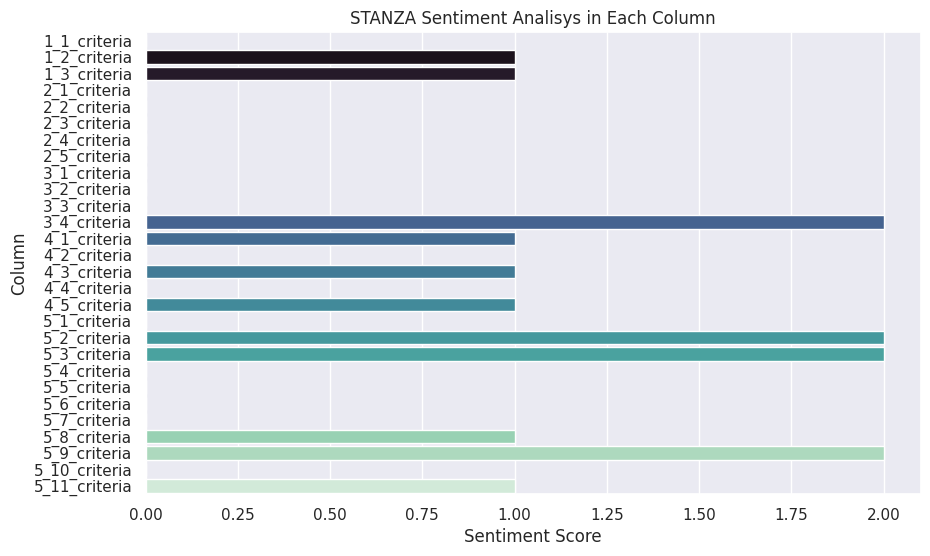

In [79]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Average Sentiment", y="Column", data=stanza_result_df, palette="mako")
plt.title("STANZA Sentiment Analisys in Each Column")
plt.xlabel("Sentiment Score")
plt.ylabel("Column")
plt.show()

- Using pre-trained sentiment analysis models without fine-tuning can be a useful technique within Exploratory Data Analysis (EDA). Although this approach has its limitations, it can provide insights into large sets of textual data, especially in the early stages of exploring and understanding the data. Applying sentiment analysis can help you get a quick overview of the tone or emotional nature of the data, identifying general trends of positive, negative or neutral sentiment. 

- Pay attention: Sentiment analysis without fine-tuning should be seen as a complement to, and not a substitute for, more in-depth and specific analysis.

